# keyword_preprocessing

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from util import dbhelper

## 1. 데이터 전처리 (1)

### 1) 구두점, 이모지, 영어 제거

In [3]:
## 1) 구두점, 이모지, 영어 제거
def only_ks(df):
    df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df['review'].replace('', np.nan, inplace=True)
    
    return df

### 2) null값 제거, index 재정렬

In [4]:
## 2) null값 제거, index 재정렬
def remove_null(df):
    df.dropna(how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

### 3) 자음/모음 중복 제거

In [5]:
## 3) 자음/모음 중복 제거
def no_repeat(df):
    review_copy = df['review'].copy()
    revised_review = []
    for i in range(len(review_copy)):
        temp = re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅃㅉㄸㄲㅆㅛㅕㅑㅐㅔㅗㅓㅏㅣㅜㅠㅡ]', '', review_copy[i])
        revised_review.append(temp)

    return df.assign(review = [i for i in revised_review])

### 4) 공백만 있는 행 제거, index 재정렬

In [6]:
## 4) 공백만 있는 행 제거, index 재정렬
def remove_whitespace(df):
    df['review'] = df['review'].str.replace('^ +', "")
    df['review'].replace('', np.nan, inplace=True)
    df.dropna(subset=['review'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

### 5) 중복행 제거, index 재정렬

In [7]:
## 5) 중복행 제거, index 재정렬
def remove_dupli(df):
    df.drop_duplicates(subset=['review'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

### 6) 맞춤법 검사

In [8]:
## 6) 맞춤법 검사
import requests
from hanspell import spell_checker
from hanspell.constants import CheckResult

def spell_check(df):
    for i in tqdm(range(len(df))):
        try:
            if len(df['review'][i]) > 500:
                continue
            result_train = spell_checker.check(df['review'][i]) 
            df['review'][i] = result_train.as_dict()['checked']
        except:
            pass

    return df

## 2. 데이터 전처리 (2)

### 1) labeling

In [10]:
# score labeling 
data['key_label'] = np.select([data.key_score > 3], [1], default=0)
data

,name,score,review,label
0,MUST STAY 호텔 선유도,5,좋은데 좁고 방음이 안돼요,1
1,MUST STAY 호텔 선유도,4,방 크기는 작아요 저렴해서 좋습니다 조명 밝아서 좋아요,0
2,MUST STAY 호텔 선유도,3,편하고 좋아요,0
3,MUST STAY 호텔 선유도,5,구성비가 좋았어요,1
4,MUST STAY 호텔 선유도,5,좋아요,1
...,...,...,...,...
178859,스타즈 호텔 독산,5,이부자리가 편했어요,1
178860,스타즈 호텔 독산,5,깨끗하고 시설도 깨끗하니 너무 좋아요,1
178861,스타즈 호텔 독산,5,좋아 요요 오옹,1
178862,스타즈 호텔 독산,5,엄청 친절하시고 방도 아담하고 편의점도 층에 있어서 편했어요,1


In [11]:
posi = 0
nega = 0
for i in tqdm(range(len(data))):
    if data['key_label'][i] > 3:
        posi += 1
    else:
        nega += 1
print("\n전체 리뷰 : {}".format(len(data['key_label'])))
print("4점 이상 : {}\n3점 이하 리뷰 : {}".format(posi, nega))

100%|███████████████████████████████| 178864/178864 [00:01<00:00, 123691.52it/s]


전체 리뷰 : 178864
5점 리뷰 : 124516
4점 이하 리뷰 : 54348



### 2) 훈련 데이터와 테스트 데이터 분리 (train: 야놀자 0.75 / test : 야놀자 0.25)

In [12]:
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 134148
테스트용 리뷰의 개수 : 44716


### 3) 훈련 데이터의 레이블의 분포 확인

   label  count
0      0  40758
1      1  93390


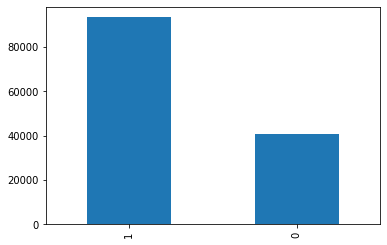

In [13]:
train_data['key_label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('key_label').size().reset_index(name = 'count'))

### 4) 훈련/테스트 데이터 - 토큰화, 불용어 제거

In [14]:
stop_words = ['있', '했', '었', '잘', '어', '어서', '거', '분', '주', '음', '고', '이', '하', '는', '에', '가', '도',
             '았', '다', '게', '들', '어요', '습니다', '을', '아요', '같', '되', '한', '방', '에서', '지', '시', '것', '호텔',
             '기', '라', '면', '나', '해서', '만', '합니다', '로', '요', '를', '해', '적', '으로', '많', '곳', '할', 
              '아서', '때', '서', '아', '의', '수', '보', '던', '빼', '물', '더', '과', '겠', '긴', '함', '니', '쉬', '건', 
              '듯', '인', '많이', '그리고', '예약', '였', '받', '번', '생각', '위치', '싶', '셨', '방문', '말', '점', '정도', 
              '네요', '은', '층', '바로', '갑니다', '먹', '숙소', '해요', '이용', '그', '오', '보다', '이랑', '으면', '또', 
              '데', '그래도', '라고', '두', '편', '까지', '된', '다고', '프런트', '체크인', '오래', '매우', '진짜', '정말']

In [15]:
# 훈련 데이터를 토큰화 후 필요없는 토큰은 제거
mecab = Mecab()
train_data['tokenized_review'] = train_data['review'].apply(mecab.morphs)
train_data['tokenized_review'] = train_data['tokenized_review'].apply(lambda x: [item for item in x if item not in stop_words])

In [16]:
# 테스트 데이터를 토큰화 후 필요없는 토큰은 제거
test_data['tokenized_review'] = test_data['review'].apply(mecab.morphs)
test_data['tokenized_review'] = test_data['tokenized_review'].apply(lambda x: [item for item in x if item not in stop_words])

### 5) 단어와 길이 분포 확인하기

In [17]:
# 각 레이블에 따라 단어들 리스트 저장
positive_words = np.hstack(train_data[train_data.score_label == 1]['tokenized_review'].values)
negative_words = np.hstack(train_data[train_data.score_label == 0]['tokenized_review'].values)

In [18]:
# 긍정 리뷰에 대해 빈도수가 높은 상위 20개 단어 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(50))

[('좋', 67373), ('너무', 20312), ('친절', 14904), ('깨끗', 13786), ('깔끔', 12639), ('는데', 9567), ('직원', 7594), ('만족', 7558), ('지만', 7072), ('시설', 6420), ('최고', 5244), ('입니다', 5198), ('객실', 5088), ('없', 4919), ('안', 4778), ('뷰', 4612), ('편하', 4363), ('조식', 4260), ('좀', 4258), ('침대', 4147), ('청결', 3898), ('다음', 3746), ('굿', 3648), ('룸', 3586), ('가격', 3571), ('항상', 3480), ('아주', 3367), ('넓', 3332), ('조금', 3287), ('괜찮', 3244), ('서비스', 3155), ('구성비', 3077), ('않', 2958), ('왔', 2640), ('자주', 2624), ('셔서', 2584), ('접근성', 2446), ('다가', 2410), ('시간', 2275), ('맛있', 2259), ('주변', 2202), ('다만', 2105), ('호', 2094), ('주차', 2089), ('캉', 2083), ('편안', 2078), ('스', 2068), ('조용', 2050), ('감사', 1974), ('역', 1943)]


In [19]:
# 부정 리뷰에 대해 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(50))

[('좋', 24342), ('는데', 9534), ('안', 9393), ('너무', 7947), ('없', 6787), ('지만', 6070), ('좀', 5516), ('친절', 4957), ('않', 4747), ('직원', 4325), ('객실', 4143), ('깨끗', 4104), ('괜찮', 3815), ('깔끔', 3761), ('시설', 3271), ('침대', 3139), ('조금', 2981), ('화장실', 2885), ('소리', 2701), ('불편', 2640), ('청소', 2478), ('만족', 2348), ('청결', 2232), ('방음', 2221), ('가격', 2170), ('입니다', 2165), ('룸', 2141), ('냄새', 2137), ('조식', 2106), ('뷰', 2076), ('다른', 2056), ('먼지', 2034), ('그냥', 1959), ('시간', 1897), ('주차', 1860), ('별로', 1809), ('좁', 1785), ('서비스', 1768), ('작', 1721), ('더라고요', 1682), ('아니', 1679), ('못', 1660), ('다만', 1638), ('아쉬웠', 1634), ('은데', 1615), ('느낌', 1514), ('인데', 1451), ('다시', 1370), ('구성비', 1314), ('접근성', 1289)]


긍정 리뷰의 평균 길이 : 7.9766
부정 리뷰의 평균 길이 : 14.5044


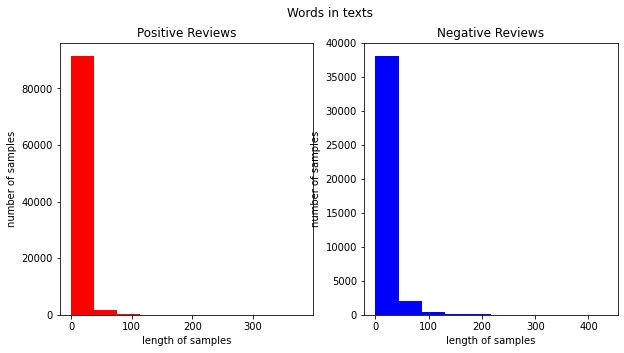

In [20]:
# 긍정 리뷰와 부정 리뷰의 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

text_len = train_data[train_data['key_label']==1]['tokenized_review'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', round(np.mean(text_len), 4))

text_len = train_data[train_data['key_label']==0]['tokenized_review'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', round(np.mean(text_len), 4))

plt.show()

In [21]:
# 훈련 데이터와 테스트 데이터 값 나눠어서 넣기
X_train = train_data['tokenized_review'].values
y_train = train_data['key_label'].values
X_test= test_data['tokenized_review'].values
y_test = test_data['key_label'].values

### 6) 정수 인코딩

In [22]:
# 훈련 데이터에 대해서 단어 집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  


threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0 
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100, 4))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100, 4))

단어 집합(vocabulary)의 크기 : 24263
등장 빈도가 1번 이하인 희귀 단어의 수: 9792
단어 집합에서 희귀 단어의 비율: 40.3577
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7329


In [23]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 개수는 제거
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 14473


In [24]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
# X_train 데이터의 상위 3개의 샘플만 출력
print(X_train[:3])

# X_test 데이터의 상위 3개의 샘플만 출력
print(X_test[:3])

[[2, 1477, 20, 1869], [80, 92, 7], [116, 24]]
[[846, 738], [1049, 2446, 4886], [7, 2, 1507, 2]]


### 7) 패딩

In [26]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 433
리뷰의 평균 길이 : 9.959954676923994


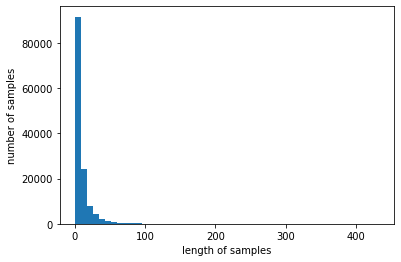

In [27]:
# 전체 데이터의 길이 분포
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# 전체 샘플 중 최대 길이 이하인 샘플의 비율을 계산
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [29]:
# 훈련용 리뷰에서 몇 개의 샘플들을 보전 가능한지 확인
max_len = 425
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 425 이하인 샘플의 비율: 99.99850910934191


In [30]:
# 훈련용 리뷰를 max_len 길이로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [29]:
# 훈련용 리뷰에서 몇 개의 샘플들을 보전 가능한지 확인
max_len = 425
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 425 이하인 샘플의 비율: 99.99850910934191
